In [37]:
import os
import pandas as pd
import keras as k
import numpy as np
import string
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sktext
import re
import math
import sklearn.metrics as matrics
import seaborn as sns
import matplotlib.pyplot as plt
from stop_words import get_stop_words
%matplotlib inline

In [52]:
def title_one_hot(title,maxlen):
    
    def one(num,length):
        vec = np.zeros(length)
        vec[num] = 1
        return vec
    
    alphabet1=list(string.ascii_lowercase)+[' ', '\'' ,','] #Add space and apostrophe to our alphabets
    alphabet = dict((c, i) for i, c in enumerate(alphabet1))
    alphabet_ = dict((i, c) for i, c in enumerate(alphabet1))
    d = maxlen - len(title)
    title = title + " "*d
    data = [one(alphabet[char],len(alphabet1)) for char in title]
    return np.asarray(data)

        
def class_one_hot(class_,list_unique_of_classes):
    one_hot_vec = np.zeros([len(list_unique_of_classes)])
    one_hot_vec[list_unique_of_classes.index(class_)] = 1
    return one_hot_vec



def from_one_hot_to_char(arr): 
    a = []
    alphabet1=list(string.ascii_lowercase)+[' ', '\'' , ','] #Add space and apostrophe to our alphabets
    alphabet = dict((c, i) for i, c in enumerate(alphabet1))
    alphabet_ = dict((i, c) for i, c in enumerate(alphabet1))
    for ii in arr:
        a.append([alphabet_[i] for i,l in enumerate(ii) if int(l)==1][0])
    return "".join(a)

def from_one_hot_class_to_str(matrix,list_unique_classes):
    class_dic = dict((class_, i) for i, class_ in enumerate(list_unique_classes))
    for i,n in enumerate(matrix):
        if n == 1:
            return list(class_dic.keys())[list(class_dic.values())[i]]
        
def clean_data(x):
    alphabet1=list(string.ascii_lowercase)+[' ', '\'' ,'\,']
    x = re.sub('[^'+"".join(alphabet1)+']', ' ', x).lower()
    x = re.sub('  +', ' ', x)
    return x.lstrip()

def text_to_bag_of_words(X,countVect):
    X_train_vectorized = countVect.fit_transform(X)
    return X_train_vectorized.toarray()

# Read Data

In [53]:
data = pd.read_csv('uci-news-aggregator.csv')

In [54]:
filterd_data = pd.DataFrame(data={"title":data.TITLE ,"category":data.CATEGORY})
#clean data from very large titles
filterd_data.drop(filterd_data[filterd_data.title.apply(len) >100].index,inplace=True)
filterd_data.title = filterd_data.title.apply(clean_data)
filterd_data.category = filterd_data.category.apply(clean_data)
data = None

In [55]:
filterd_data.head(2)

,category,title
0,b,"ed official says weak data caused by weather, ..."
1,b,ed's harles losser sees high bar for change in...


In [56]:
unique_classes = list(filterd_data.category.unique())
filterd_data.category.value_counts()

e    152462
b    115967
t    108342
m     45639
Name: category, dtype: int64

In [57]:
max_len_of_title = filterd_data.title.apply(len).max()
max_len_of_title

89

# Start training

In [82]:
X , Y = filterd_data.title , filterd_data.category
# x , x_rest , y , y_rest = train_test_split(X, Y, test_size=0.95, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=0)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=0)

In [83]:
stop_words = get_stop_words('en')
uniq = set(" ".join(filterd_data.title).split(' '))
uniq = set([i for i in uniq if i not in stop_words])
countVect = sktext.CountVectorizer(vocabulary=uniq,stop_words='english')

# encoding

In [84]:
#================================work with batches=============================
class generate_one_batch:
    def __init__(self,batch_size,dataset):
        self.batch_size = batch_size
        self.dataset = dataset
        self.start = 0

    def get_batch(self):
        end = self.start+self.batch_size 
        diff = end - len(self.dataset)
        if diff > 0 :
            if diff < self.batch_size :
                end = len(self.dataset)
            else:
                self.start = 0
                end = self.batch_size
        returned_batch = self.dataset[self.start:end]
        self.start +=  self.batch_size
        return returned_batch 



def data_generator(title_generator,categorical_generator):
    while True:
        x = title_generator.get_batch()
        x = text_to_bag_of_words(x,countVect)
        y = categorical_generator.get_batch()
        y = y.apply(lambda x: class_one_hot(x,unique_classes))
        y = np.stack(y,axis=0)
        yield (x, y)
            
#===========================================================================

batch_size = 1024
epoch_num = 10
saving_path = 'result/'
experiment_name = "experiment_nn_BOW1"



checkpoint_path_ = saving_path+experiment_name+"/checkpoints/"
experiment_path = saving_path+experiment_name+"/"
result_path = saving_path+experiment_name+"/result/"
try:
    os.makedirs(checkpoint_path_)
    os.makedirs(result_path)
except OSError as e:
    print("Can't create file")
    
checkpoint_path = checkpoint_path_ + "experiment-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# ===========================================================================
title_batch_generator = generate_one_batch(batch_size=batch_size, dataset=x_train)
category_encoded_batch_generator = generate_one_batch(batch_size=batch_size, dataset=y_train)
steps_per_epoch = math.ceil(len(x_train) / batch_size)

title_batch_generator_val = generate_one_batch(batch_size=batch_size, dataset=x_val)
category_encoded_batch_generator_val = generate_one_batch(batch_size=batch_size, dataset=y_val)
validation_steps = math.ceil(len(x_val) / batch_size)
# ===========================================================================

Can't create file


# build NN

In [86]:
model = k.models.Sequential()
model.add(k.layers.Dense(40,input_shape=(len(uniq),),activation ='relu'))
model.add(k.layers.Dense(40,activation ='relu'))

model.add(k.layers.Dense(units = len(unique_classes),activation = 'softmax'))          
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

# check points

In [87]:
checkpoint = k.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# ===========================tensorboard=====================================
tensorboard = k.callbacks.TensorBoard(log_dir=result_path,
                                          histogram_freq=0,
                                          batch_size=batch_size,
                                          write_graph=True,
                                          write_grads=True,
                                          write_images=True,
                                          embeddings_freq=0,
                                          embeddings_layer_names=None,
                                          embeddings_metadata=None)

callbacks = [checkpoint , tensorboard]

# Fit Model

In [88]:
# =============================Fitting Model=================================
hist = model.fit_generator(generator = data_generator(title_batch_generator,category_encoded_batch_generator),
                           steps_per_epoch=steps_per_epoch,
                           validation_data = data_generator(title_batch_generator_val, category_encoded_batch_generator_val),
                           validation_steps=validation_steps,
                           epochs=epoch_num,
                           use_multiprocessing=True,
                           callbacks=callbacks,
                           verbose=1)

Epoch 1/10
265/265 [==============================] - 1094s 4s/step - loss: 0.4473 - acc: 0.8788 - val_loss: 0.2124 - val_acc: 0.9266

Epoch 00001: val_acc improved from -inf to 0.92661, saving model to result/experiment_nn_BOW1/checkpoints/experiment-improvement-01-0.93.hdf5
Epoch 2/10
265/265 [==============================] - 1118s 4s/step - loss: 0.1642 - acc: 0.9436 - val_loss: 0.2035 - val_acc: 0.9288

Epoch 00002: val_acc improved from 0.92661 to 0.92885, saving model to result/experiment_nn_BOW1/checkpoints/experiment-improvement-02-0.93.hdf5
Epoch 3/10
265/265 [==============================] - 1109s 4s/step - loss: 0.1262 - acc: 0.9567 - val_loss: 0.2118 - val_acc: 0.9277

Epoch 00003: val_acc did not improve
Epoch 4/10
265/265 [==============================] - 1105s 4s/step - loss: 0.1048 - acc: 0.9640 - val_loss: 0.2247 - val_acc: 0.9261

Epoch 00004: val_acc did not improve
Epoch 5/10
  9/265 [>.............................] - ETA: 15:34 - loss: 0.1008 - acc: 0.9651

Process Process-24:


KeyboardInterrupt: 

In [89]:
df_results = pd.DataFrame(data = hist.history)
df_results.to_csv(experiment_path+"results_lists.csv")

NameError: name 'hist' is not defined

# Evaluation

In [91]:
# Encode X_test data
x_test_encoding =text_to_bag_of_words(x_test,countVect)
y_test_encoding = [unique_classes.index(i) for i in y_test]

In [92]:
# load max vall_acc model '
checkpoints_path_list = os.listdir(checkpoint_path_)
all_checkpoints_list = [os.path.join(checkpoint_path_,i) for i in checkpoints_path_list]
#Get the last inserted weight into the checkpoint_path
all_checkpoints_list_sorted = sorted(all_checkpoints_list, key=os.path.getmtime)
epochs_list = [int(re.findall(r'-[0-9|.]*-',path)[0].replace('-',"")) for path in all_checkpoints_list_sorted]
max_checkpoint = all_checkpoints_list_sorted[epochs_list.index(max(epochs_list))]
#load weights
print(max_checkpoint)
max_model = k.models.load_model(max_checkpoint)

result/experiment_nn_BOW1/checkpoints/experiment-improvement-02-0.93.hdf5


In [93]:
predictions = max_model.predict(x_test_encoding)
predictions = [int(np.where(i==i.max())[0]) for i in predictions]

In [94]:
print("Accuracy : ", matrics.accuracy_score(y_test_encoding, predictions))
print("Recall : ", matrics.recall_score(y_test_encoding, predictions, average = 'weighted'))
print("Precision : ", matrics.precision_score(y_test_encoding, predictions, average = 'weighted'))
print("F1 : ", matrics.f1_score(y_test_encoding, predictions, average = 'weighted'))

Accuracy :  0.928363438365569
Recall :  0.928363438365569
Precision :  0.9285770168313147
F1 :  0.9284117854710392


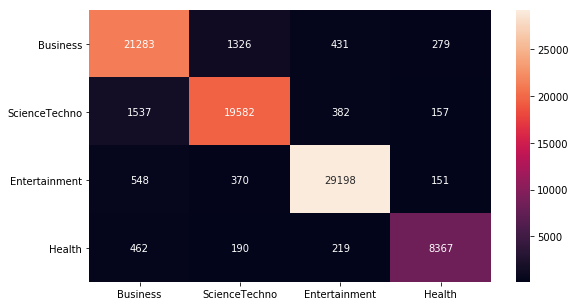

In [95]:
fig1 = plt.figure(figsize=(9, 5))
confusion_mat = matrics.confusion_matrix(y_test_encoding, predictions)
lables = ['Business', 'ScienceTechno', 'Entertainment', 'Health']
sns.heatmap(confusion_mat, xticklabels=lables, yticklabels=lables, annot=True, fmt="d")